# Classificação de Sentimentos com Redes Neurais Convolucionais

## Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy as sp
import string

import random
import re
import math
from bs4 import BeautifulSoup

In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [3]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

## Base de dados

In [4]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

### Dados de teste

In [5]:
test_data = pd.read_csv('../../_IAExpert_private/7. Processamento de Linguagem Natural com Deep LEarning/trainingandtestdata/test.csv', 
                        header=None, 
                        names=cols, 
                        engine="python", 
                        encoding='latin1')
print(test_data.shape)
test_data.sample(5, random_state=0)

(498, 6)


,sentiment,id,date,query,user,text
90,0,212,Mon May 25 17:23:55 UTC 2009,bailout,funky_old_man,Are YOU burning more cash $$$ than Chrysler an...
254,4,1019,Mon May 11 05:21:25 UTC 2009,lebron,undefeated310,Watching Lebron highlights. Damn that niggas good
283,2,2100,Sun May 17 17:30:03 UTC 2009,san francisco,bKnapp,"breakers. in San Francisco, CA http://loopt.us..."
443,4,2532,Sun Jun 07 01:13:23 UTC 2009,jquery,ghurson,"I'm ready to drop the pretenses, I am forever ..."
336,0,2185,Mon May 25 17:26:30 UTC 2009,insects,euthanasia86,Just got barraged by a horde of insects hungry...


### Dados de treinamento

In [6]:
train_data = pd.read_csv('../../_IAExpert_private/7. Processamento de Linguagem Natural com Deep LEarning/trainingandtestdata/train.csv', 
                        header=None, 
                        names=cols, 
                        engine="python", 
                        encoding='latin1')
print(train_data.shape)
train_data.sample(5, random_state=0)

(1600000, 6)


,sentiment,id,date,query,user,text
557138,0,2204444171,Wed Jun 17 02:14:00 PDT 2009,NO_QUERY,einmensch,wants to compete! i want hard competition! i w...
349381,0,2017152437,Wed Jun 03 07:56:34 PDT 2009,NO_QUERY,keithmorrison,It seems we are stuck on the ground in Amarill...
182051,0,1967043408,Fri May 29 18:52:13 PDT 2009,NO_QUERY,PunkieDory,where the f are my pinking shears? rarararrrar...
571236,0,2208721054,Wed Jun 17 09:32:48 PDT 2009,NO_QUERY,DYkEY_tYPE,0ff t0 tHE MEEtiN.. i HAtE WhEN PPl V0lUNtEER...
1339637,4,2018731586,Wed Jun 03 10:25:27 PDT 2009,NO_QUERY,BlueSmartiies,@ reply me pls


C:\Users\mjuli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

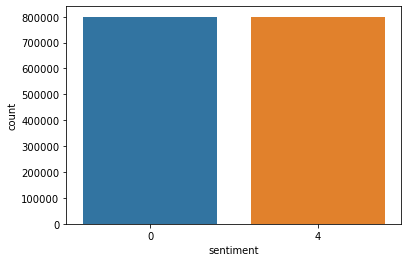

In [7]:
sns.countplot(train_data.sentiment)

C:\Users\mjuli\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

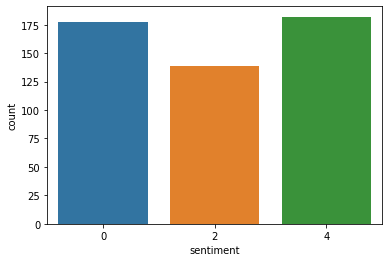

In [8]:
sns.countplot(test_data.sentiment)

## Pré-processamento dos dados

In [9]:
data = train_data
data.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True)
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [10]:
data.sentiment.value_counts(dropna=False)

0    800000
4    800000
Name: sentiment, dtype: int64

In [11]:
X = data.text.values
y = data.sentiment.values

X.shape, y.shape

((1600000,), (1600000,))

In [12]:
X, _, y, _ = train_test_split(X, y, test_size=0.85, stratify=y) # train datasets
X.shape, y.shape

((240000,), (240000,))

In [13]:
unique, counts = np.unique(y, return_counts=True)
uniqueue, counts

(array([0, 4], dtype=int64), array([120000, 120000], dtype=int64))

### preprocessamento do texto

In [82]:
def clean_tweets(tweet: str) -> str:
    tweet = BeautifulSoup(tweet, 'lxml').get_text()
    tweet = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet)
    tweet = re.sub(r"[^a-zA-Z.!?]", " ", tweet)
    tweet = re.sub(r" +", " ", tweet)
    
    return tweet

In [244]:
text = pd.Series(X).sample(1).values[0]
print('before:',text)
print('after:',clean_tweets(text))

before: @crucify_brett Hey, you wouldn't be a meanie &amp; set Fritz on me, would you? And i love Fritz 
after:  Hey you wouldn t be a meanie set Fritz on me would you? And i love Fritz 


### stop-words

In [246]:
nlp = sp.load('en_core_web_sm')
nlp

In [251]:
stop_words = sp.lang.en.STOP_WORDS
len(stop_words)

326

In [271]:
def clean_tweets(tweet: str) -> str:
    tweet = BeautifulSoup(tweet, 'lxml').get_text()
    tweet = re.sub(r"@[A-Za-z0-9_]+", " ", tweet)
    tweet = re.sub(r"'", "", tweet)
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet)
    tweet = re.sub(r"[^a-zA-Z.!?]", " ", tweet)
    tweet = re.sub(r" +", " ", tweet)
    
    tweet = tweet.lower()
    document = nlp(tweet)
    
    words = []
    for token in document:
        words.append(token.text)
    
    words = [word for word in words if word not in stop_words and word not in string.punctuation]
    cleaned_tweet = ' '.join([str(element) for element in words])
    
    return cleaned_tweet

In [268]:
text = pd.Series(X).sample(1).values[0]
print('before:',text)
print('after:',clean_tweets(text))

before: @RhyseRichards even better reasons to text me 
after:   better reasons text


### aplicação na base de dados

In [272]:
data_clean = [clean_tweets(tweet) for tweet in X]
len(data_clean)

240000

In [273]:
data_labels = y
data_labels[data_labels==4]=1
np.unique(data_labels)

array([0, 1], dtype=int64)

## Tokenização

In [278]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, 
                                                                    target_vocab_size=2**16)

In [280]:
print(2**16)
tokenizer.vocab_size

65536


52401

In [281]:
print(tokenizer.subwords)

['  ', 'nt_', 'm_', ' ... ', 's_', 'good_', ' .. ', 'like_', 'got_', 'day_', 'going_', 'love_', 'u_', ' ...', 'work_', 'time_', 'know_', 'today_', 'new_', 'want_', 'think_', 'oh_', 'lol_', 'need_', 'hope_', 'thanks_', 'night_', 'ill_', 'home_', 've_', 'great_', 'miss_', 'feel_', ' .... ', 'd_', 'wish_', 'day', 'morning_', 'na_', 'twitter_', 'lol', 'gon_', 'getting_', 'today', 'bad_', 'happy_', 'watching_', 'haha_', 'way_', 'tomorrow_', 'come_', 'sorry_', ' ..', 'sad_', 'nice_', 'work', 'fun_', 'sleep_', 'yeah_', 'wait_', 'n_', 'hate_', 'hey_', 'right_', 'people_', 'better_', 'bed_', 'tonight_', 'having_', 'yes_', 'school_', 'little_', 'y_', 'wo_', 'long_', 'wanna_', 'week_', 'time', 'thank_', 'best_', 'awesome_', 'feeling_', 'ok_', 'days_', 'ur_', 'working_', 'watch_', 'good', 'looking_', 'went_', 'ready_', 'tomorrow', 'night', 'sure_', 'find_', 'trying_', 't_', 'look_', 'nt', 'e_', 'r_', 'maybe_', 'man_', 'life_', 'o_', 'tired_', 'pretty_', 'friends_', 'weekend_', 'love', 'thing_', 'g

In [282]:
ids = tokenizer.encode('i am happy')
ids

[298, 4141, 369]

In [283]:
text = tokenizer.decode(ids)
text

'i am happy'

In [ ]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]
len(data_inputs)